In [1]:
#import warnings
#warnings.filterwarnings('ignore')

import datacube

import matplotlib.pyplot as plt
import matplotlib.cm as color_maps  
from matplotlib.pyplot import figure, cm

import json
import time
import sys
import os

import rasterio
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.merge import merge
from rasterio.plot import show

import rioxarray as rio

import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from osgeo import ogr, gdal

from datetime import datetime
#from time import time

import skimage
from skimage import exposure
from skimage import morphology
from skimage.morphology import disk
from skimage.morphology import rectangle
from skimage.filters import rank

import glob
import fiona
import subprocess

import utils.data_cube_utilities.dc_utilities as utils
from utils.data_cube_utilities.data_access_api import DataAccessApi
from utils.data_cube_utilities.dc_utilities import write_geotiff_from_xr, write_png_from_xr
from utils.data_cube_utilities.dc_chunker import create_geographic_chunks, combine_geographic_chunks
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic, create_mosaic
from utils.data_cube_utilities.dc_sar_utils import dn_to_db 

from rmmeh.vanilla import rmmeh

In [2]:
def rasterization(InputVector,OutputImage,RefImage):
    gdalformat = 'GTiff'
    datatype = gdal.GDT_Byte
    burnVal = 1 #value for the output image pixels
    ##########################################################
    # Get projection info from reference image
    Image = gdal.Open(RefImage, gdal.GA_ReadOnly)
    print(Image)

    # Open Shapefile
    Shapefile = ogr.Open(InputVector)
    Shapefile_layer = Shapefile.GetLayer()

    # Rasterising
    print("Rasterising shapefile...")
    Output = gdal.GetDriverByName(gdalformat).Create(OutputImage, Image.RasterXSize, Image.RasterYSize, 1, datatype, options=['COMPRESS=DEFLATE'])
    Output.SetProjection(Image.GetProjectionRef())
    Output.SetGeoTransform(Image.GetGeoTransform()) 

    # Write data to band 1
    Band = Output.GetRasterBand(1)
    Band.SetNoDataValue(0)
    gdal.RasterizeLayer(Output, [1], Shapefile_layer, burn_values=[burnVal])

    # Close datasets
    Band = None
    Output = None
    Image = None
    Shapefile = None

    # Build image overviews
    subprocess.call("gdaladdo --config COMPRESS_OVERVIEW DEFLATE "+OutputImage+" 2 4 8 16 32 64", shell=True)


    print("Done.")

    print('finist_rasterise_vector')
    
def rgb(dataset, bands = ['nir', 'red', 'green'], paint_on_mask = []):
    
    fig=plt.figure()
    fig.set_size_inches(9, 9)
    
    rgb = np.stack([dataset[bands[0]], dataset[bands[1]], dataset[bands[2]]], axis = -1)
    rgb = rgb.astype(np.float32)

    p2, p98 = np.percentile(rgb, (2, 98))
    rgb = exposure.rescale_intensity(rgb, in_range=(p2, p98)) * 255.0

    rgb = rgb.astype(int) 

    for mask, color in paint_on_mask:        
        rgb[mask] = np.array([256,256,256]) - np.array(color).astype(np.int16)
    plt.imshow(rgb)
        
def generate_cloud_mask(dataset, include_shadows = False):
    #Create boolean Masks for clear and water pixels
      
    clear_pixels = dataset.pixel_qa.values == (2 ) 
    water_pixels = dataset.pixel_qa.values == (4 )
    shadow_pixels= dataset.pixel_qa.values == (3 )
           
    #a_clean_mask = np.logical_or(clear_pixels, water_pixels)
    a_clean_mask = np.logical_or(1, 1)
    if include_shadows:
        a_clean_mask = np.logical_or(a_clean_mask, shadow_pixels)
        
    return np.invert(a_clean_mask)

def mrf_mosaic(dataset):
    # The mask here is based on pixel_qa products. It comes bundled in with most Landsat Products.
    cloud_free_boolean_mask = np.invert(generate_cloud_mask(dataset))
    #cloud_free_boolean_mask = generate_cloud_mask(dataset)
    return create_mosaic(dataset, clean_mask = cloud_free_boolean_mask)

## 1. Initialization

In [5]:
sugarcane_shp = './shp/clipped_sugarcane.shp'
rice_shp = './shp/clipped_rice.shp'

longitude_extents = (99.6901, 99.8776)
latitude_extents = (16.5634, 16.4344)

platform = "SENTINEL_2_Thailand"
product = "s2_level2a_Thailand"
                      
bands = ['coastal', 
         'blue', 'green', 'red', 
         #'veg5', 'veg6', 'veg7', 
         'nir', 'narrow_nir', 
         #'water_vapour', 'swir1', 'swir2', 
         'AOT', 'pixel_qa']
         #'SCL', 'WVP', 'AOT', 'pixel_qa']

dc = datacube.Datacube(app = 'my_app', config = '/home/ubuntu/.datacubeThailandS2.conf')

time_extents = ('2019-05-01', '2021-05-31')
#time_extents = ('2020-01-01', '2021-05-31')

n_sample = 10000
safety_factor = 1.5

result_file = ("x_train", "y_train")

## 2. Get sentinel2 data from ODC as the same size and resolution of input raster

In [6]:
start_time = time.time()
print("Mem status before loading dataset")
!cat /proc/meminfo | grep Mem

s2_dataset = dc.load(latitude = latitude_extents,
                     longitude = longitude_extents,
                     #latitude = (latitude_extents[0], midpoint[0]),
                     #longitude = (longitude_extents[0], midpoint[1]),
                     platform = platform,
                     time = time_extents,
                     product = product,
                     measurements = bands)

print("loading time:", time.time() - start_time,"Sec.")

print("Mem status after dataset loaded")
!cat /proc/meminfo | grep Mem


Mem status before loading dataset
MemTotal:       132028380 kB
MemFree:        71245176 kB
MemAvailable:   101557264 kB
loading time: 139.4235725402832 Sec.
Mem status after dataset loaded
MemTotal:       132028380 kB
MemFree:        64239492 kB
MemAvailable:   94551616 kB


In [7]:
#s2_dataset.to_netcdf("odc_on_disk.nc")

s2_dataset

<xarray.Dataset>
Dimensions:     (latitude: 1394, longitude: 2026, time: 156)
Coordinates:
  * time        (time) datetime64[ns] 2019-05-05T04:03:48.860000 ... 2021-05-29T04:03:41.640000
  * latitude    (latitude) float64 16.56 16.56 16.56 16.56 ... 16.43 16.43 16.43
  * longitude   (longitude) float64 99.69 99.69 99.69 ... 99.88 99.88 99.88
Data variables:
    coastal     (time, latitude, longitude) int16 652 652 652 ... 5152 5152 5152
    blue        (time, latitude, longitude) int16 880 821 893 ... 5436 5296 5124
    green       (time, latitude, longitude) int16 1200 1228 1242 ... 4852 4852
    red         (time, latitude, longitude) int16 1214 1192 1306 ... 4544 4528
    nir         (time, latitude, longitude) int16 2930 3012 3068 ... 5036 4972
    narrow_nir  (time, latitude, longitude) int16 3222 3222 3408 ... 5194 5194
    AOT         (time, latitude, longitude) int16 456 456 456 ... 204 204 204
    pixel_qa    (time, latitude, longitude) int16 5 5 5 5 5 5 5 ... 9 9 9 9 9 9
Attributes:
    crs:      EPSG:4326

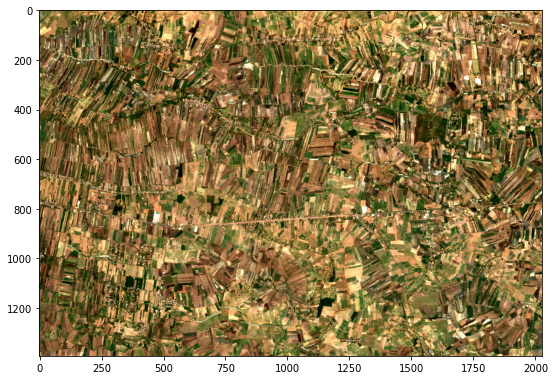

In [8]:
s2_mosaic=mrf_mosaic(s2_dataset)
s2_mosaic

#draw image
rgb(s2_mosaic, bands=['red','green','blue'])

#save mosaic to GeoTIFF and will be use as RefImage 
measurements = ['red', 'green', 'blue']
RefImage = './refImage.tif'
write_geotiff_from_xr(RefImage, s2_mosaic, measurements)

In [9]:
#Image area in sq.km.
1652*1317*(100)/(1000*1000)

217.5684

## 1. read shape file

In [10]:
def records(file):  
    # generator 
    reader = ogr.Open(file)
    layer = reader.GetLayer(0)
    result = []
    for i in range(layer.GetFeatureCount()):
        feature = layer.GetFeature(i)
        polygon = json.loads(feature.ExportToJson())
        geojson = json.dumps(polygon['geometry'])
        tmp_polygon = ogr.CreateGeometryFromJson(geojson)
        result.append(tmp_polygon)
    return result
        
def in_polygon(lat, lon, shp_records):
    point = ogr.Geometry(ogr.wkbPoint)
    point.AddPoint(lon, lat)

    for i, polygon in enumerate(shp_records):
        if point.Within(polygon):
            return True
        
    return False

In [11]:
sugarcane_area = records(sugarcane_shp)
rice_area = records(rice_shp)

In [12]:
#try in-polygon test
sugar_point = (16.4006, 99.7045)
rice_point = (16.3647, 99.6797)

print("is sugar_point in sugar_area", in_polygon(sugar_point[0], sugar_point[1], sugarcane_area))
print("is sugar_point in rice_area", in_polygon(sugar_point[0], sugar_point[1], rice_area))
print("is rice_point in sugar_area", in_polygon(rice_point[0], rice_point[1], sugarcane_area))
print("is rice_point in rice_area", in_polygon(rice_point[0], rice_point[1], rice_area))

is sugar_point in sugar_area True
is sugar_point in rice_area False
is rice_point in sugar_area False
is rice_point in rice_area True


### Create Raster

In [13]:
InputVector = sugarcane_shp
OutputImage = 'clipped_sugarcane.tif'
rasterization(InputVector,OutputImage,RefImage)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7feb5bdfb870> >
Rasterising shapefile...
Done.
finist_rasterise_vector


In [14]:
InputVector = rice_shp
OutputImage = 'clipped_rice.tif'
rasterization(InputVector,OutputImage,RefImage)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7feb5ac9bc90> >
Rasterising shapefile...
Done.
finist_rasterise_vector


## 3. Sampling locations from (1.)

In [15]:
print(len(s2_dataset.latitude.data), len(s2_dataset.longitude.data))

1394 2026


In [20]:
real_sugar = rasterio.open('clipped_sugarcane.tif')
real_rice = rasterio.open('clipped_rice.tif')
print(real_sugar.height, real_sugar.width)

sugar_pix = real_sugar.read(1)
rice_pix = real_rice.read(1)


1394 2026


In [ ]:
import random

#list of (lat,lon)
sugarcane_points = []
rice_points = []
other_points = []


sugarcane_ji = []
rice_ji = []
other_ji = []

labels = []
#n_sample = 5
count = 0

print("start_sampling n=",(len(s2_dataset.latitude.data)*len(s2_dataset.longitude.data)))

#while len(sugarcane_points) < n_sample*safety_factor or len(rice_points) < n_sample*safety_factor :
for j in range(len(s2_dataset.latitude.data)) : 
    for i in range(len(s2_dataset.longitude.data)) : 
        lat = s2_dataset.latitude.data[j]
        lon = s2_dataset.longitude.data[i]


        #if in_polygon(lat, lon, sugarcane_area):
        if rice_pix[j][i]==0 and sugar_pix[j][i]==1:
            #print(lat, lon)
            #print("sugar")
            sugarcane_points.append((lat,lon))
            sugarcane_ji.append((j,i))
            #label.append(1)
        #elif in_polygon(lat, lon, rice_area):
        elif rice_pix[j][i]==1 and sugar_pix[j][i]==0:
            #print(lat, lon)
            #print("rice")
            rice_points.append((lat,lon))
            rice_ji.append((j,i))
            #label.append(2)
        else:
            other_points.append((lat,lon))
            other_ji.append((j,i))
            #label.append(0)
        count += 1
        if count<10 or count%10000 == 0:
            print("iteration:", count, "sugarcane_points:", len(sugarcane_points), "rice_points:", len(rice_points), "other_points:", len(other_points))


## 4. get NDVI value from (2) using locations from (3) 

 $$ {NDVI} = \frac{(X_{NIR}-X_{Red})}{(X_{NIR}+X_{Red})}$$


In [28]:
#filter only rows that has number of zero-value less than 10%

def filter_row(all_points, max_n_sample):
    week_year_array = None
    tmp_array = None
    location = None
    for (lat,lon) in all_points:
        pixel_mosaic = s2_dataset.sel(latitude=lat, longitude=lon)
        pixel_mosaic
        tmp_ndvi = ((pixel_mosaic['nir'].values - pixel_mosaic['red'].values).astype(np.double)/
                          (pixel_mosaic['nir'].values + pixel_mosaic['red'].values + .0001).astype(np.double))

        tmp_ndwi =  ((pixel_mosaic['green'].values - pixel_mosaic['nir'].values).astype(np.double)/
                          (pixel_mosaic['green'].values + pixel_mosaic['nir'].values + .0001).astype(np.double))

        R = pixel_mosaic['red'].values.astype(np.double)
        G = pixel_mosaic['green'].values.astype(np.double)
        B = pixel_mosaic['blue'].values.astype(np.double)
        nir = pixel_mosaic['nir'].values.astype(np.double)
        narrow_nir = pixel_mosaic['narrow_nir'].values.astype(np.double)
        
        tmp_df = pd.DataFrame({'timestamp': pixel_mosaic['time'].values, 
                               'ndvi': tmp_ndvi,
                              'ndwi': tmp_ndwi,
                              'red': R,
                              'green': G,
                              'blue': B,
                              'nir': nir, 
                              'narrow_nir': narrow_nir, })
        
        tmp_df['week_year'] = tmp_df['timestamp'].dt.strftime("%Y-%U")
        tmp_df = tmp_df[['week_year', 'ndvi', 'ndwi', 'red', 'green', 'blue', 'nir', 'narrow_nir']].groupby('week_year').max()
        tmp_df = tmp_df.reset_index()
        
        if week_year_array is None:
            week_year_array = tmp_df['week_year'].to_numpy()
        
        #SMOOTHING WITH RMMEH FUNCTION
        tmp_df['smooth_ndvi'] = rmmeh(tmp_df['ndvi'], median_window=7)
        tmp_df['smooth_ndwi'] = rmmeh(tmp_df['ndwi'], median_window=7)
        tmp_df['smooth_red'] = rmmeh(tmp_df['red'], median_window=7)
        tmp_df['smooth_green'] = rmmeh(tmp_df['green'], median_window=7)
        tmp_df['smooth_blue'] = rmmeh(tmp_df['blue'], median_window=7)
        tmp_df['smooth_nir'] = rmmeh(tmp_df['nir'], median_window=7)
        tmp_df['smooth_narrow_nir'] = rmmeh(tmp_df['narrow_nir'], median_window=7)
        
        
        n_snapshot = len(week_year_array)
        
        #print(tmp_df['smooth_ndvi'].to_numpy())
        
        #if number of zero-value > 10% then skip this row
        #if (tmp_df['smooth_ndvi'] == 0).sum() > n_snapshot*0.1:
        #    continue
            
        if tmp_array is None:
            tmp_array = np.array([[tmp_df['smooth_ndvi'].to_numpy(), 
                                  tmp_df['smooth_ndwi'].to_numpy(), 
                                  tmp_df['smooth_red'].to_numpy(), 
                                  tmp_df['smooth_green'].to_numpy(), 
                                  tmp_df['smooth_blue'].to_numpy(), 
                                  tmp_df['smooth_nir'].to_numpy(), 
                                  tmp_df['smooth_narrow_nir'].to_numpy()
                                 ]]
                                )
            #print("TEST")
            #print(tmp_array.shape)
            location = np.array([[lat,lon]])
            
        elif len(tmp_array) < max_n_sample:
            tmp_array = np.append(tmp_array,
                                   np.array([[tmp_df['smooth_ndvi'].to_numpy(),
                                  tmp_df['smooth_ndwi'].to_numpy(), 
                                  tmp_df['smooth_red'].to_numpy(), 
                                  tmp_df['smooth_green'].to_numpy(), 
                                  tmp_df['smooth_blue'].to_numpy(), 
                                  tmp_df['smooth_nir'].to_numpy(), 
                                  tmp_df['smooth_narrow_nir'].to_numpy()
                                 ]]), 
                                   axis=0)
                                 
            location = np.append(location,
                                 np.array([[lat,lon]]),
                                 axis=0)
                                 
    return (week_year_array, location ,tmp_array)


In [29]:
print('sugar')
(week_year_array, sugar_location ,sugar_data) = filter_row(sugarcane_points, n_sample)
print('rice')
(week_year_array, rice_location ,rice_data) = filter_row(rice_points, n_sample)
print('other')
(week_year_array, other_location ,other_data) = filter_row(other_points, n_sample)

sugar


KeyboardInterrupt: 

In [ ]:
data_array = np.concatenate((sugar_data, rice_data, other_data))
data_array.shape


In [ ]:
all_location = np.concatenate((sugar_location, rice_location, other_location))
all_location.shape

In [ ]:
all_ji = np.array(sugarcane_ji+rice_ji+other_ji)
all_ji.shape

In [ ]:
labels = []
for x in range(0, len(sugar_location)+len(rice_location)+len(other_location)):
    if x < len(sugar_location):
        labels.append(1)
    elif x < len(sugar_location)+len(rice_location):
        labels.append(2)
    else:
        labels.append(0)
        

labels = np.array(labels)
len(labels)

In [ ]:
len(week_year_array)

## 5. Sampling 50 rows from sugarcane data and plot

## 6. Export numpy array

In [ ]:
#Save to NPY format
np.savez("testSetRasterKPP.npz", x=data_array, y=labels, location=all_location, position=all_ji, weeks = week_year_array)